# <center>Anomaly Detection</center>

In [1]:
#Import all necessary libraries   
import tensorflow
import keras 
from keras import optimizers, regularizers
from keras.models import Sequential, Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from keras.optimizers import RMSprop,adam,Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.preprocessing import MinMaxScaler

import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


## Visualization Class
### Overview
- The Visualization class is designed to assist in visualizing the results of anomaly detection models. It provides methods for creating visualizations of confusion matrices, anomaly detection results, and error plots.
### Class Members
#### labels
#### Description: A list of labels used for classification, typically containing "Normal" and "Anomaly" labels.
##### Type: List of strings
- draw_confusion_matrix(self, y, ypred)
##### Description: Generates a heatmap-based confusion matrix to visualize the performance of a classification model.
##### Parameters:
- y (array-like): True labels.
- ypred (array-like): Predicted labels.
### draw_anomaly(self, y, error, threshold)
##### Description: Plots data points, highlighting anomalies and normal instances based on a specified threshold.
##### Parameters:
- y (array-like): True labels (1 for anomalies, 0 for normal instances).
- error (array-like): Reconstruction errors or anomaly scores.
- threshold (float): Threshold for classifying anomalies.
### draw_error(self, error, threshold)
##### Description: Visualizes reconstruction errors alongside a user-defined threshold for anomaly detection.
##### Parameters:
- error (array-like): Reconstruction errors or anomaly scores.
- threshold (float): Threshold for classifying anomalies.


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")
        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [3]:
#loding Dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df.shape

(284807, 31)

## Transform dataset  

In [6]:
df["Amount"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1,1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0,df1])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , df['Class'], test_size=0.2, random_state=42)

In [8]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (16320, 29)
Test shape: (4080, 29)


## Model creation

In [9]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 12)                360       
                                                                 
 dense_1 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [10]:
#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                360       
                                                                 
 dense_3 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [11]:
#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                480       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 29)                493 

In [12]:
autoencoder.compile(optimizer=RMSprop(), loss='mean_squared_error',metrics=['mae', 'accuracy'])

In [13]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 [==============================] - 6s 8ms/step - loss: 1.4658 - mae: 0.6745 - accuracy: 0.2502 - val_loss: 1.5410 - val_mae: 0.6625 - val_accuracy: 0.4037
Epoch 2/20
510/510 [==============================] - 4s 7ms/step - loss: 1.4237 - mae: 0.6565 - accuracy: 0.4274 - val_loss: 1.5278 - val_mae: 0.6601 - val_accuracy: 0.4745
Epoch 3/20
510/510 [==============================] - 3s 6ms/step - loss: 1.4086 - mae: 0.6547 - accuracy: 0.5094 - val_loss: 1.5144 - val_mae: 0.6587 - val_accuracy: 0.5581
Epoch 4/20
510/510 [==============================] - 4s 7ms/step - loss: 1.4007 - mae: 0.6536 - accuracy: 0.5623 - val_loss: 1.5101 - val_mae: 0.6580 - val_accuracy: 0.5787
Epoch 5/20
510/510 [==============================] - 4s 8ms/step - loss: 1.3986 - mae: 0.6531 - accuracy: 0.5768 - val_loss: 1.5086 - val_mae: 0.6576 - val_accuracy: 0.5902
Epoch 6/20
510/510 [==============================] - 4s 8ms/step - loss: 1.3976 - mae: 0.6528 - accuracy: 0.5883 - val_loss: 1.50

In [14]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 1s 4ms/step - loss: 1.5038 - mae: 0.6567 - accuracy: 0.6324
Test loss: 1.5038200616836548
Test accuracy: 0.6567485928535461


In [15]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 [==============================] - 1s 3ms/step


In [16]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.65      0.69      0.67        93

    accuracy                           0.98      4080
   macro avg       0.82      0.84      0.83      4080
weighted avg       0.98      0.98      0.98      4080



In [17]:
roc_auc_score(y_test, y_label)

0.8398221639683812

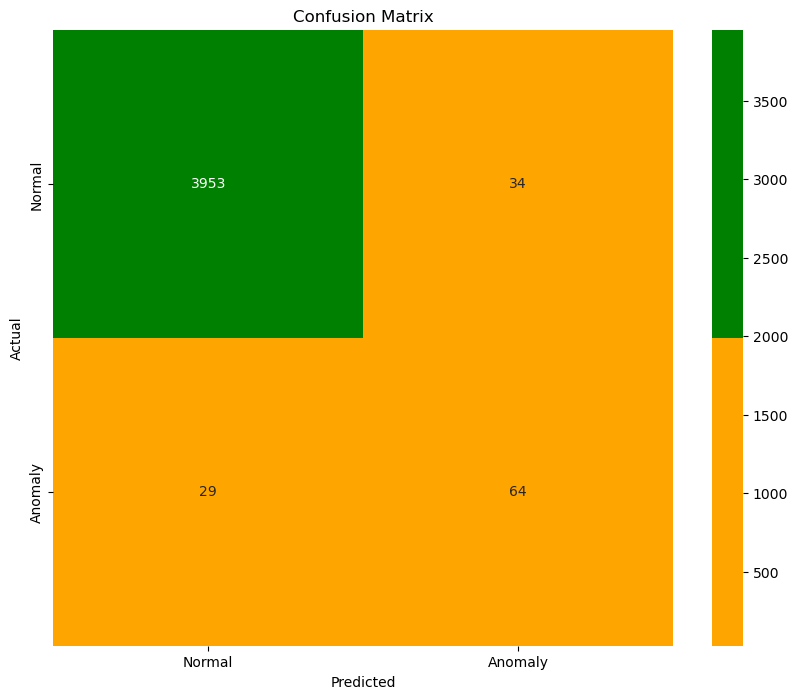

In [18]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

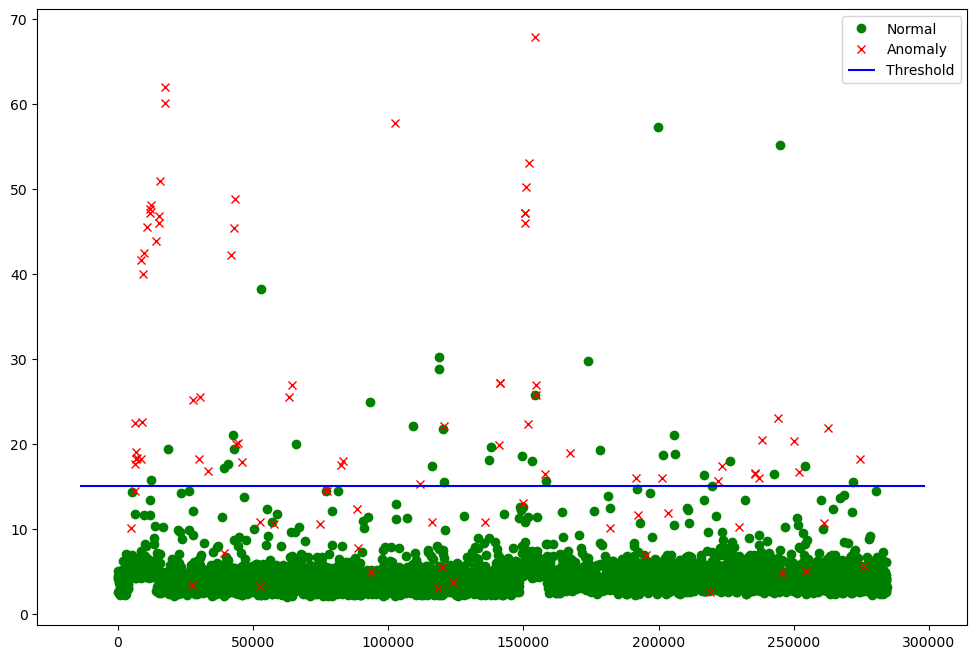

In [19]:
viz.draw_anomaly(y_test, error, threshold)